In [2]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc4jupyter

  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-04fdejy6
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-04fdejy6
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit 5741c522547756ac4bb7a16df32106a15efb8a57
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for nvcc4jupyter: filename=nvcc4jupyter-1.2.1-py3-none-any.whl size=10741 sha256=1c43b610d84440f376c57bb0b3d20f87e2433fdb6f06eb98d5fd7c81c461a971
  Stored in directory: /tmp/pip-ephem-wheel-cache-blgt89pc/wheels/a8/b9/18/23f8ef71ceb0f63297dd1903aedd067e6243a68ea756d6feea
Successfully built nvcc4jupyter
Detected platform "Colab". Running its setup...
Source files will be saved in "/tmp/tmp_c_3_bxs".


In [9]:
!git clone https://github.com/nothings/stb.git
!cp stb/stb_image.h /usr/local/include/
!cp stb/stb_image_write.h /usr/local/include/

fatal: destination path 'stb' already exists and is not an empty directory.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%%writefile mask.txt
3
0 0 0
0 1 0
0 0 0

Writing mask.txt


In [10]:
%%writefile k1.cu
// %%writefile k1.cu
#define STB_IMAGE_IMPLEMENTATION
#define K 3
#include <stdio.h>

#include "stb_image.h"
#define STB_IMAGE_WRITE_IMPLEMENTATION
#include "stb_image_write.h"
// #include <windows.h>
#include <filesystem>
#include <string>
#include <vector>
#include <iostream>


#define STB_IMAGE_IMPLEMENTATION
#define STB_IMAGE_WRITE_IMPLEMENTATION
#define MASK_DIM 3

// __constant__ float mask[MASK_DIM * MASK_DIM];

// __global__
// void convolution_3D_batch_kernel(unsigned char *in, unsigned char *out, int w, int h, int comp, int batch_size) {
//     int Col = blockIdx.x * blockDim.x + threadIdx.x;
//     int Row = blockIdx.y * blockDim.y + threadIdx.y;
//     int image_idx = blockIdx.z;

//     if (Col < w && Row < h) {
//         int pixVal_R = 0;
//         int pixVal_G = 0;
//         int pixVal_B = 0;
//         int N_start_col = Col - (MASK_DIM/2);
//         int N_start_row = Row - (MASK_DIM/2);

//             if (image_idx < batch_size) {
//             int index_base = image_idx * (w * h * comp);
//             for(int j = 0; j < MASK_DIM; ++j) {
//                 for(int k = 0; k < MASK_DIM; ++k) {
//                     int curRow = N_start_row + j;
//                     int curCol = N_start_col + k;
//                     if(curRow > -1 && curRow < h && curCol > -1 && curCol < w) {
//                         int index = index_base + ((curRow * w + curCol) * comp);
//                         float mask_value = mask[j * MASK_DIM + k];
//                         pixVal_R += in[index] * mask_value;
//                         pixVal_G += in[index + 1] * mask_value;
//                         pixVal_B += in[index + 2] * mask_value;
//                     }
//                 }
//             }
//         }

//         int index = ((image_idx * w * h) + (Row * w + Col));
//         out[index] = ((unsigned char)(pixVal_R) + (unsigned char)(pixVal_G) + (unsigned char)(pixVal_B))/3;
//     }
// }

__global__
void convolution_3D_batch_kernelDA(unsigned char *in, unsigned char *out, int w, int h, int comp, int batch_size, float *mask,int mask_dim) {
    extern __shared__ float shared_mask[];
    int Col = blockIdx.x * blockDim.x + threadIdx.x;
    int Row = blockIdx.y * blockDim.y + threadIdx.y;
    int image_idx = blockIdx.z;
    // if (threadIdx.x < mask_dim && threadIdx.y < mask_dim) {
    //     shared_mask[threadIdx.y * mask_dim + threadIdx.x] = mask[threadIdx.y * mask_dim + threadIdx.x];
    // }
    // the mask size could exceed the block size
    for (int i = threadIdx.y; i < mask_dim; i += blockDim.y) {
        for (int j = threadIdx.x; j < mask_dim; j += blockDim.x) {
            if ( i < mask_dim && j < mask_dim) {
                shared_mask[i * mask_dim + j] = mask[i * mask_dim + j];
            }
        }
    }
    __syncthreads();

    if (Col < w && Row < h) {
        float pixVal_R = 0;
        float pixVal_G = 0;
        float pixVal_B = 0;
        int N_start_col = Col - (mask_dim/2);
        int N_start_row = Row - (mask_dim/2);

        if (image_idx < batch_size) {
            int index_base = image_idx * (w * h * comp);
            for(int j = 0; j < mask_dim; ++j) {
                for(int k = 0; k < mask_dim; ++k) {
                    int curRow = N_start_row + j;
                    int curCol = N_start_col + k;
                    if(curRow > -1 && curRow < h && curCol > -1 && curCol < w) {
                        int index = index_base + ((curRow * w + curCol) * comp);
                        float mask_value = shared_mask[j * mask_dim + k];
                        pixVal_R += in[index] * mask_value;
                        pixVal_G += in[index + 1] * mask_value;
                        pixVal_B += in[index + 2] * mask_value;
                    }
                }
            }
        }

        int index = ((image_idx * w * h) + (Row * w + Col));
        // out[index] = ((unsigned char)(pixVal_R) + (unsigned char)(pixVal_G) + (unsigned char)(pixVal_B));
        // max between 0 and min between 255 and the value
        out[index] = (unsigned char) max(0, min(255, (unsigned char) (pixVal_R + pixVal_G + pixVal_B)));
    }
}

std::vector<std::string> listFiles(const std::string &folderPath) {
    std::vector<std::string> files;

    try {
        for (const auto &entry : std::filesystem::directory_iterator(folderPath)) {
            if (!entry.is_directory()) {
                files.push_back(entry.path().filename().string());
            }
        }
    } catch (const std::filesystem::filesystem_error &e) {
        std::cerr << "Error reading directory: " << e.what() << std::endl;
    }

    return files;
}

// std::vector<std::string> listFiles(const std::string &folderPath) {
//   std::vector<std::string> files;

//       WIN32_FIND_DATA findFileData;
//       HANDLE hFind = FindFirstFile((folderPath + "\\*").c_str(), &findFileData);
//       if (hFind == INVALID_HANDLE_VALUE) {
//           std::cerr << "Error opening directory! Error code: " << GetLastError() << std::endl;
//           return files;
//       }

//       do {
//           // Exclude directories "." and ".."
//           if (strcmp(findFileData.cFileName, ".") != 0 && strcmp(findFileData.cFileName, "..") != 0) {
//               // Add file name to vector
//               files.push_back(findFileData.cFileName);
//           }
//       } while (FindNextFile(hFind, &findFileData) != 0);

//       DWORD dwError = GetLastError();
//       if (dwError != ERROR_NO_MORE_FILES) {
//           std::cerr << "Error reading directory! Error code: " << dwError << std::endl;
//       }

//       FindClose(hFind);

//       return files;
// }

int main(int argc, char *argv[]) {
    if (argc != 5) {
        printf("Usage: %s input_folder_path output_folder_path batch_size mask.txt\n", argv[0]);
        return 1;
    }

    FILE *mask_file = fopen(argv[4], "r");
    if (!mask_file) {
        printf("Error opening mask file!\n");
        return 1;
    }

    int mask_dim;
    fscanf(mask_file, "%d", &mask_dim);
    float *host_mask = new float[mask_dim * mask_dim];
    for (int i = 0; i < mask_dim; ++i) {
        for (int j = 0; j < mask_dim; ++j) {
            fscanf(mask_file, "%f", &host_mask[i * mask_dim + j]);
        }
    }
    fclose(mask_file);
    float *d_mask;
    cudaMalloc(&d_mask, mask_dim * mask_dim * sizeof(float));
    cudaMemcpy(d_mask, host_mask, mask_dim * mask_dim * sizeof(float), cudaMemcpyHostToDevice);

    printf("Reading image...\n");

    std::vector<std::string> files = listFiles(argv[1]);
    int batch_size = atoi(argv[3]);
    int width, height, comp;
    unsigned char *d_in, *d_out;

    std::vector<unsigned char> imageData;
    int totalSize = 0;
    for (int b = 0; b < batch_size; ++b) {
        char input_image_path[100];
        sprintf(input_image_path, "%s/%s", argv[1], files[b].c_str());
        unsigned char *data = stbi_load(input_image_path, &width, &height, &comp, 0);
        int size = width * height * comp;
        totalSize += size;
        std::cout << "width = " << width << ", height = " << height << ", comp = " << comp << std::endl;
        imageData.insert(imageData.end(), data, data + size);
        stbi_image_free(data);
    }

    cudaMalloc(&d_in, batch_size * width * height * comp);
    cudaMalloc(&d_out, batch_size * width * height);
    std::cout << "Size of the vector: " << imageData.size() << std::endl;

    cudaMemcpy(d_in, imageData.data(), totalSize * sizeof(unsigned char), cudaMemcpyHostToDevice);

        // convolution_3D_batch_kernel<<<dim3((width + 16 - 1) / 16, (height + 16 - 1) / 16, batch_size), dim3(16, 16)>>>(d_in, d_out, width, height, comp, batch_size);
        convolution_3D_batch_kernelDA<<<dim3((width + 16 - 1) / 16, (height + 16 - 1) / 16, batch_size), dim3(16, 16), mask_dim * mask_dim * sizeof(float)>>>(d_in, d_out, width, height, comp, batch_size, d_mask,mask_dim);
        unsigned char *out = (unsigned char *)malloc(batch_size * width * height);
        cudaMemcpy(out, d_out, batch_size * width * height, cudaMemcpyDeviceToHost);

        for (int b = 0; b < batch_size; ++b) {
            char output_image_path[100];
            sprintf(output_image_path, "%s/image_%d.jpg", argv[2], b);
            stbi_write_jpg(output_image_path, width, height, 1, out + b * (width * height), 100);
        }

        free(out);
        cudaFree(d_in);
        cudaFree(d_out);

        return 0;
}




Overwriting k1.cu


In [11]:
!nvcc ./k1.cu -o k1.out

In [ ]:
 !./k1.out img out 3  mask.txt

Error opening mask file!


In [12]:
%%writefile mask5.txt
5
0 0 0 0 0
0 0 0 0 0
0 0 1 0 0
0 0 0 0 0
0 0 0 0 0

Writing mask5.txt


In [13]:
%%writefile mask7.txt
7
0 0 0 0 0 0 0
0 0 0 0 0 0 0
0 0 0 0 0 0 0
0 0 0 1 0 0 0
0 0 0 0 0 0 0
0 0 0 0 0 0 0
0 0 0 0 0 0 0

Writing mask7.txt


In [14]:
%%writefile mask9.txt
9
0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0
0 0 0 0 1 0 0 0 0
0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0

Writing mask9.txt


In [ ]:
!nvprof ./k1.out img out 3 mask9.txt

==5902== NVPROF is profiling process 5902, command: ./k1.out img out 3 mask9.txt
Reading image...
width = 5000, height = 5000, comp = 3
width = 5000, height = 5000, comp = 3
width = 5000, height = 5000, comp = 3
Size of the vector: 225000000
==5902== Profiling application: ./k1.out img out 3 mask9.txt
==5902== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   57.02%  133.73ms         1  133.73ms  133.73ms  133.73ms  convolution_3D_batch_kernelDA(unsigned char*, unsigned char*, int, int, int, int, float*, int)
                   22.42%  52.576ms         1  52.576ms  52.576ms  52.576ms  [CUDA memcpy DtoH]
                   20.56%  48.220ms         2  24.110ms  1.1520us  48.219ms  [CUDA memcpy HtoD]
      API calls:   55.64%  235.98ms         3  78.660ms  21.590us  187.50ms  cudaMemcpy
                   43.60%  184.93ms         3  61.642ms  163.30us  184.30ms  cudaMalloc
                    0.66%  2.8163ms         2  1

In [ ]:
# import cv2
# image = cv2.imread('img/image_0.jpg')
# cv2.imwrite('img/image_2.jpg', image)

True

In [ ]:
!nvprof ./k3.out img out 3 mask9.txt

Reading image...
width = 5000, height = 5000, comp = 3
width = 5000, height = 5000, comp = 3
width = 5000, height = 5000, comp = 3
==5999== NVPROF is profiling process 5999, command: ./k3.out img out 3 mask9.txt
Size of the vector: 225000000
==5999== Profiling application: ./k3.out img out 3 mask9.txt
==5999== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   51.91%  108.98ms         1  108.98ms  108.98ms  108.98ms  convolution_3D_input_kernelwds(unsigned char*, unsigned char*, int, int, int, int, int, float*)
                   25.30%  53.120ms         1  53.120ms  53.120ms  53.120ms  [CUDA memcpy DtoH]
                   22.79%  47.849ms         2  23.925ms  1.1840us  47.848ms  [CUDA memcpy HtoD]
      API calls:   51.97%  211.31ms         3  70.435ms  16.003us  163.22ms  cudaMemcpy
                   47.56%  193.37ms         3  64.456ms  147.34us  193.05ms  cudaMalloc
                    0.37%  1.4868ms         2  

In [ ]:
!nvprof ./k2.out img out 3 mask9.txt

======== Error: application not found.


In [65]:
%%writefile k2.cu
// %%writefile k3.cu
//input tile
#define STB_IMAGE_IMPLEMENTATION
#define K 3
#include <stdio.h>

#include "stb_image.h"
#define STB_IMAGE_WRITE_IMPLEMENTATION
#include "stb_image_write.h"
// #include <windows.h>
#include <filesystem>
#include <string>
#include <vector>
#include <iostream>


#define STB_IMAGE_IMPLEMENTATION
#define STB_IMAGE_WRITE_IMPLEMENTATION
#define MASK_DIM 3
// #define MASK_DIM 3
#define THREADS_PER_BLOCK_X 18
#define THREADS_PER_BLOCK_Y 18
#define MASK_WIDTH 3
#define MASK_RADIUS 1

#define  O_TILE_WIDTH 16
#define  BLOCK_WIDTH 32


__global__
void convolution_3D_input_kernelwds(unsigned char * in, unsigned char * out, int w, int h, int comp, int batch_size,int maskWidth, float * mask2,int output_tile_dim) {
    // int Col = blockIdx.x * blockDim.x + threadIdx.x;
    // int Row = blockIdx.y * blockDim.y + threadIdx.y;
    int image_idx = blockIdx.z;
    int threads_per_block_x = blockDim.x;
    int threads_per_block_y = blockDim.y;
    /////////////////
    // int shared_mem_size = (threads_per_block_y ) * (threads_per_block_x) * 3 * sizeof(unsigned char);

    // Dynamically allocate shared memory for tiles
    extern __shared__ unsigned char shared_mem[];
    // each thread loads one element from the input list into the shared memory
    unsigned char* tile_R = shared_mem;
    unsigned char* tile_G = tile_R + (threads_per_block_y ) * (threads_per_block_x );
    unsigned char* tile_B = tile_G + (threads_per_block_y ) * (threads_per_block_x );

    float *mask3 = (float*)(tile_B + (threads_per_block_y ) * (threads_per_block_x ));
    // if (threadIdx.x < maskWidth && threadIdx.y < maskWidth) {
    //     mask3[threadIdx.y * maskWidth + threadIdx.x] = mask2[threadIdx.y * maskWidth + threadIdx.x];
    // }
    for (int i = threadIdx.y; i < maskWidth; i += blockDim.y) {
        for (int j = threadIdx.x; j < maskWidth; j += blockDim.x) {
            if ( i < maskWidth && j < maskWidth) {
                mask3[i * maskWidth + j] = mask2[i * maskWidth + j];
            }
        }
    }

    int tx = threadIdx.x;
    int ty = threadIdx.y;
    // output tile indeces
    int row_o = blockIdx.y * output_tile_dim + ty;
    int col_o = blockIdx.x * output_tile_dim + tx;
    ///////////////////////////
    // input tile indeces
    int row_i = row_o - maskWidth/2;
    int col_i = col_o - maskWidth/2;
    ////////////////////
    int tile_idx = (ty) * (threads_per_block_x) + (tx);
    if (image_idx < batch_size){

    if (row_i >= 0 && row_i < h && col_i >= 0 && col_i < w) {
        tile_R[tile_idx] = in[(image_idx * w * h * comp) + (row_i * w + col_i) * comp];
        tile_G[tile_idx] = in[(image_idx * w * h * comp) + (row_i * w + col_i) * comp + 1];
        tile_B[tile_idx] = in[(image_idx * w * h * comp) + (row_i * w + col_i) * comp + 2];
    } else {
        tile_R[tile_idx] = 0;
        tile_G[tile_idx] = 0;
        tile_B[tile_idx] = 0;
    }
    __syncthreads();
    // printf("gg");
    if (row_o < h && col_o < w && ty <  output_tile_dim && tx < output_tile_dim){
        float sum = 0;
        float maskValue;
        for (int i = 0; i < maskWidth; i++)
        {
            for (int j = 0; j < maskWidth; j++)
            {
               // int tile_idx = (ty + i) * (threads_per_block_x) + (tx + j);
                maskValue= mask3[i * maskWidth + j];
                sum += tile_R[(ty + i) * (threads_per_block_x) + (tx + j)] * maskValue + tile_G[(ty + i) * (threads_per_block_x) + (tx + j)] *maskValue + tile_B[(ty + i) * (threads_per_block_x) + (tx + j)] * maskValue;
            }
        }

        //int index = ((image_idx * w * h) + (row_o * w + col_o));
        // out[((image_idx * w * h) + (row_o * w + col_o))] = (sum);
        out[((image_idx * w * h) + (row_o * w + col_o))] = (unsigned char) max(0, min(255, (unsigned char) (sum)));
    }
}
}

// std::vector<std::string> listFiles(const std::string &folderPath) {
//   std::vector<std::string> files;

//       WIN32_FIND_DATA findFileData;
//       HANDLE hFind = FindFirstFile((folderPath + "\\*").c_str(), &findFileData);
//       if (hFind == INVALID_HANDLE_VALUE) {
//           std::cerr << "Error opening directory! Error code: " << GetLastError() << std::endl;
//           return files;
//       }

//       do {
//           // Exclude directories "." and ".."
//           if (strcmp(findFileData.cFileName, ".") != 0 && strcmp(findFileData.cFileName, "..") != 0) {
//               // Add file name to vector
//               files.push_back(findFileData.cFileName);
//           }
//       } while (FindNextFile(hFind, &findFileData) != 0);

//       DWORD dwError = GetLastError();
//       if (dwError != ERROR_NO_MORE_FILES) {
//           std::cerr << "Error reading directory! Error code: " << dwError << std::endl;
//       }

//       FindClose(hFind);

//       return files;
// }


std::vector<std::string> listFiles(const std::string &folderPath) {
    std::vector<std::string> files;

    try {
        for (const auto &entry : std::filesystem::directory_iterator(folderPath)) {
            if (!entry.is_directory()) {
                files.push_back(entry.path().filename().string());
            }
        }
    } catch (const std::filesystem::filesystem_error &e) {
        std::cerr << "Error reading directory: " << e.what() << std::endl;
    }

    return files;
}


int main(int argc, char *argv[]) {
    if (argc != 5) {
        printf("Usage: %s input_folder_path output_folder_path batch_size mask.txt\n", argv[0]);
        return 1;
    }

    FILE *mask_file = fopen(argv[4], "r");
    if (!mask_file) {
        printf("Error opening mask file!\n");
        return 1;
    }

    int mask_dim;
    fscanf(mask_file, "%d", &mask_dim);
    float *host_mask = (float *)malloc(mask_dim * mask_dim * sizeof(float));

    for (int i = 0; i < mask_dim; ++i) {
        for (int j = 0; j < mask_dim; ++j) {
            fscanf(mask_file, "%f", &host_mask[i * mask_dim + j]);
        }
    }
    fclose(mask_file);


    printf("Reading image...\n");

    std::vector<std::string> files = listFiles(argv[1]);
    int batch_size = atoi(argv[3]);
    int width, height, comp;
    unsigned char *d_in, *d_out;


    std::vector<unsigned char> imageData;
    int totalSize = 0;
    // int padded_width, padded_height;
    for (int b = 0; b < batch_size; ++b) {
        char input_image_path[100];
        sprintf(input_image_path, "%s/%s", argv[1], files[b].c_str());
        // int width1, height1, comp1;
        unsigned char *data = stbi_load(input_image_path, &width, &height, &comp, 0);
        int size = width * height * comp;
        totalSize += size;
        // print width, height, comp
        std::cout << "width = " << width << ", height = " << height << ", comp = " << comp << std::endl;
        imageData.insert(imageData.end(), data, data + size);
        stbi_image_free(data);
    }

    cudaMalloc(&d_in, batch_size * width * height * comp);
    cudaMalloc(&d_out, batch_size * width * height);
    // print the vector size
    std::cout << "Size of the vector: " << imageData.size() << std::endl;

    // Copy the concatenated image data to the GPU
    cudaMemcpy(d_in, imageData.data(), totalSize * sizeof(unsigned char), cudaMemcpyHostToDevice);

        // convolution_3D_input_kernelw<<<dim3((width + 16 - 1) / 16, (height + 16 - 1) / 16, batch_size), dim3(16, 16)>>>(d_in, d_out, width, height, comp, batch_size);
        // int BLOCK_WIDTH = O_TILE_WIDTH + mask_dim - 1;
        int output_tile_dim = BLOCK_WIDTH - mask_dim - 1;
        dim3 dimBlock(BLOCK_WIDTH, BLOCK_WIDTH);
        dim3 dimGrid((width - 1)/output_tile_dim +1, (height - 1)/output_tile_dim +1, batch_size);

      float *d_mask;
      cudaMalloc(&d_mask, mask_dim * mask_dim * sizeof(float));
      cudaMemcpy(d_mask, host_mask, mask_dim * mask_dim * sizeof(float), cudaMemcpyHostToDevice);

    //
        int shared_mem_size = 3 * (BLOCK_WIDTH) * (BLOCK_WIDTH) * sizeof(unsigned char) + mask_dim * mask_dim * sizeof(float);
        // convolution_3D_input_kernelw<<<dimGrid, dimBlock>>>(d_in, d_out, width, height, comp, batch_size);
        convolution_3D_input_kernelwds<<<dimGrid, dimBlock,shared_mem_size>>>(d_in, d_out, width, height, comp, batch_size,mask_dim,d_mask,output_tile_dim);


        unsigned char *out = (unsigned char *)malloc(batch_size * width * height);
        cudaMemcpy(out, d_out, batch_size * width * height, cudaMemcpyDeviceToHost);

        for (int b = 0; b < batch_size; ++b) {
            char output_image_path[100];
            sprintf(output_image_path, "%s/image_%d.jpg", argv[2], b);
            stbi_write_jpg(output_image_path, width, height, 1, out + b * (width * height), 100);
        }

        free(out);
        cudaFree(d_in);
        cudaFree(d_out);

        return 0;
}





Overwriting k2.cu


In [16]:
!nvcc ./k2.cu -o k2.out

In [17]:
 !./a.out img out 3  mask.txt

/bin/bash: line 1: ./a.out: No such file or directory


In [ ]:
!nvprof ./k2.out img out 3 mask.txt

Reading image...
width = 1980, height = 1289, comp = 3
width = 1980, height = 1289, comp = 3
width = 1980, height = 1289, comp = 3
==33647== NVPROF is profiling process 33647, command: ./k2.out img out 3 mask.txt
Size of the vector: 22969980
==33647== Profiling application: ./k2.out img out 3 mask.txt
==33647== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   45.05%  5.1758ms         1  5.1758ms  5.1758ms  5.1758ms  [CUDA memcpy DtoH]
                   42.87%  4.9256ms         2  2.4628ms  1.1520us  4.9245ms  [CUDA memcpy HtoD]
                   12.09%  1.3887ms         1  1.3887ms  1.3887ms  1.3887ms  convolution_3D_out_kernelwdsf2(unsigned char*, unsigned char*, int, int, int, int, int, float*)
      API calls:   93.32%  201.07ms         3  67.023ms  101.75us  200.84ms  cudaMalloc
                    5.91%  12.729ms         3  4.2429ms  14.022us  7.5855ms  cudaMemcpy
                    0.57%  1.2179ms         2 

In [18]:
%%writefile k3.cu
// %%writefile k2.cu

#define STB_IMAGE_IMPLEMENTATION
#define K 3
#include <stdio.h>

#include "stb/stb_image.h"
#define STB_IMAGE_WRITE_IMPLEMENTATION
#include "stb/stb_image_write.h"
// #include <windows.h>
#include <filesystem>
#include <string>
#include <vector>
#include <iostream>


#define STB_IMAGE_IMPLEMENTATION
#define STB_IMAGE_WRITE_IMPLEMENTATION
#define MASK_DIM 3
#define THREADS_PER_BLOCK_X 16
#define THREADS_PER_BLOCK_Y 16
#define MASK_WIDTH 3
#define MASK_RADIUS 1

__global__
void convolution_3D_out_kernelwdsf2(unsigned char * in, unsigned char * out, int w, int h,int maskWidth, int comp, int batch_size, float *mask2) {
    int Col = blockIdx.x * blockDim.x + threadIdx.x;
    int Row = blockIdx.y * blockDim.y + threadIdx.y;
    int image_idx = blockIdx.z;
    int threads_per_block_x = blockDim.x;
    int threads_per_block_y = blockDim.y;
    // Calculate the size of shared memory needed for tiles
    //int shared_mem_size = (threads_per_block_y + maskWidth - 1) * (threads_per_block_x + maskWidth - 1) * 3 * sizeof(unsigned char);

    // Dynamically allocate shared memory for tiles
    extern __shared__ unsigned char shared_mem[];

    // Linearize the shared memory for each color channel
    unsigned char* tile_R = shared_mem;
    unsigned char* tile_G = tile_R + (threads_per_block_y + maskWidth - 1) * (threads_per_block_x + maskWidth - 1);
    unsigned char* tile_B = tile_G + (threads_per_block_y + maskWidth - 1) * (threads_per_block_x + maskWidth - 1);
    float *mask3 = (float*)(tile_B + (threads_per_block_y + maskWidth - 1) * (threads_per_block_x + maskWidth - 1));
    int tx = threadIdx.x;
    int ty = threadIdx.y;
    int row_start = blockIdx.y *threads_per_block_y;
    int col_start =  blockIdx.x *threads_per_block_y;
    int index_base = image_idx * (w * h * comp);

if (Col < w && Row < h && image_idx < batch_size) {

//    if (threadIdx.x < maskWidth && threadIdx.y < maskWidth) {
//         mask3[threadIdx.y * maskWidth + threadIdx.x] = mask2[threadIdx.y * maskWidth + threadIdx.x];
//     }
    for (int i = threadIdx.y; i < maskWidth; i += blockDim.y) {
        for (int j = threadIdx.x; j < maskWidth; j += blockDim.x) {
            if ( i < maskWidth && j < maskWidth) {
                mask3[i * maskWidth + j] = mask2[i * maskWidth + j];
            }
        }
    }
    __syncthreads();

    for (int i = ty; i < threads_per_block_x + maskWidth - 1; i += blockDim.y) {
        for (int j = tx; j < threads_per_block_y + maskWidth - 1; j += blockDim.x) {
            int x_index = col_start - (maskWidth / 2) + j;
            int y_index = row_start - (maskWidth / 2) + i;

            // Calculate the linear index for accessing shared memory
            int tile_idx = ( i) * (threads_per_block_x + maskWidth - 1) + ( j);

            // Check bounds and load data into tiles
            if (x_index >= 0 && x_index < w && y_index >= 0 && y_index < h) {
                tile_R[tile_idx] = in[(y_index * w + x_index) * 3 + index_base];
                tile_G[tile_idx] = in[(y_index * w + x_index) * 3 + 1 + index_base];
                tile_B[tile_idx] = in[(y_index * w + x_index) * 3 + 2 + index_base];
            } else {
                tile_R[tile_idx] = 0;
                tile_G[tile_idx] = 0;
                tile_B[tile_idx] = 0;
            }
        }
    }

    __syncthreads();
        float sum = 0;
        float mask_val ;
        int tile_idx;
        for(int j = 0; j < maskWidth; ++j) {
            for(int k = 0; k < maskWidth; ++k) {
                // int curRow = Row - (maskWidth / 2) + j;
                // int curCol = Col - (maskWidth / 2) + k;
                // if(curRow > -1 && curRow < h && curCol > -1 && curCol < w) {
                    // Linearize the indexing for accessing tile elements
                    tile_idx = (ty + j) * (threads_per_block_x + maskWidth - 1) + (tx + k);
                    mask_val = mask3[j * maskWidth + k];
                    sum += tile_R[tile_idx] * mask_val+ tile_G[tile_idx] * mask_val+ tile_B[tile_idx] * mask_val;
                    // pixVal_G += tile_G[tile_idx] * mask3[j * maskWidth + k];
                    // pixVal_B += tile_B[tile_idx] * mask3[j * maskWidth + k];
                // }
            }
        }
        __syncthreads();
        int index = (Row * w + Col) + image_idx*w*h;
        // out[index] = ((unsigned char)(sum));
        out[index] = (unsigned char) max(0, min(255, (unsigned char) (sum)));
    }
}



std::vector<std::string> listFiles(const std::string &folderPath) {
    std::vector<std::string> files;

    try {
        for (const auto &entry : std::filesystem::directory_iterator(folderPath)) {
            if (!entry.is_directory()) {
                files.push_back(entry.path().filename().string());
            }
        }
    } catch (const std::filesystem::filesystem_error &e) {
        std::cerr << "Error reading directory: " << e.what() << std::endl;
    }

    return files;
}
// std::vector<std::string> listFiles(const std::string &folderPath) {
//   std::vector<std::string> files;

//       WIN32_FIND_DATA findFileData;
//       HANDLE hFind = FindFirstFile((folderPath + "\\*").c_str(), &findFileData);
//       if (hFind == INVALID_HANDLE_VALUE) {
//           std::cerr << "Error opening directory! Error code: " << GetLastError() << std::endl;
//           return files;
//       }

//       do {
//           // Exclude directories "." and ".."
//           if (strcmp(findFileData.cFileName, ".") != 0 && strcmp(findFileData.cFileName, "..") != 0) {
//               // Add file name to vector
//               files.push_back(findFileData.cFileName);
//           }
//       } while (FindNextFile(hFind, &findFileData) != 0);

//       DWORD dwError = GetLastError();
//       if (dwError != ERROR_NO_MORE_FILES) {
//           std::cerr << "Error reading directory! Error code: " << dwError << std::endl;
//       }

//       FindClose(hFind);

//       return files;
// }

int main(int argc, char *argv[]) {
    if (argc != 5) {
        printf("Usage: %s input_folder_path output_folder_path batch_size mask.txt\n", argv[0]);
        return 1;
    }

    FILE *mask_file = fopen(argv[4], "r");
    if (!mask_file) {
        printf("Error opening mask file!\n");
        return 1;
    }

    int mask_dim;
    fscanf(mask_file, "%d", &mask_dim);
   float *host_mask = (float *)malloc(mask_dim * mask_dim * sizeof(float));
    for (int i = 0; i < mask_dim; ++i) {
        for (int j = 0; j < mask_dim; ++j) {
            fscanf(mask_file, "%f", &host_mask[i * mask_dim + j]);
        }
    }
    fclose(mask_file);

    // cudaMemcpyToSymbol(mask, host_mask, mask_dim * mask_dim * sizeof(float));

    printf("Reading image...\n");

    std::vector<std::string> files = listFiles(argv[1]);
    int batch_size = atoi(argv[3]);
    int width, height, comp;
    unsigned char *d_in, *d_out;

std::vector<unsigned char> imageData;
int totalSize = 0;
for (int b = 0; b < batch_size; ++b) {
    char input_image_path[100];
    sprintf(input_image_path, "%s/%s", argv[1], files[b].c_str());
    // int width1, height1, comp1;
    unsigned char *data = stbi_load(input_image_path, &width, &height, &comp, 0);
    int size = width * height * comp;
    totalSize += size;
    // print width, height, comp
    std::cout << "width = " << width << ", height = " << height << ", comp = " << comp << std::endl;
    imageData.insert(imageData.end(), data, data + size);
    stbi_image_free(data);
}

cudaMalloc(&d_in, batch_size * width * height * comp);
cudaMalloc(&d_out, batch_size * width * height);
// print the vector size
std::cout << "Size of the vector: " << imageData.size() << std::endl;

// Copy the concatenated image data to the GPU
cudaMemcpy(d_in, imageData.data(), totalSize * sizeof(unsigned char), cudaMemcpyHostToDevice);

    ///
    float *d_mask;
    cudaMalloc(&d_mask, mask_dim * mask_dim * sizeof(float));
    cudaMemcpy(d_mask, host_mask, mask_dim * mask_dim * sizeof(float), cudaMemcpyHostToDevice);

    //
    // convolution_3D_out_kernelw<<<dim3((width + THREADS_PER_BLOCK_X - 1) / THREADS_PER_BLOCK_X, (height + THREADS_PER_BLOCK_X - 1) / THREADS_PER_BLOCK_X, batch_size), dim3(THREADS_PER_BLOCK_X, THREADS_PER_BLOCK_X)>>>(d_in, d_out, width, height, comp, batch_size);
    int shared_mem_size =  3 * (THREADS_PER_BLOCK_X + mask_dim -1) * (THREADS_PER_BLOCK_X + mask_dim -1) * sizeof(unsigned char) +  mask_dim * mask_dim * sizeof(float);
    convolution_3D_out_kernelwdsf2<<<dim3((width + THREADS_PER_BLOCK_X - 1) / THREADS_PER_BLOCK_X, (height + THREADS_PER_BLOCK_X - 1) / THREADS_PER_BLOCK_X, batch_size), dim3(THREADS_PER_BLOCK_X, THREADS_PER_BLOCK_X),shared_mem_size>>>(d_in, d_out, width, height,mask_dim, comp, batch_size,d_mask);
    unsigned char *out = (unsigned char *)malloc(batch_size * width * height);
    cudaMemcpy(out, d_out, batch_size * width * height, cudaMemcpyDeviceToHost);

    for (int b = 0; b < batch_size; ++b) {
        char output_image_path[100];
        sprintf(output_image_path, "%s/image_%d.jpg", argv[2], b);
        stbi_write_jpg(output_image_path, width, height, 1, out + b * (width * height), 100);
    }

    free(out);
    cudaFree(d_in);
    cudaFree(d_out);

    return 0;
}



Writing k3.cu


In [19]:
!nvcc ./k3.cu -o k3.out

./stb/stb_image.h(4275): warning #550-D: variable "old_limit" was set but never used
     unsigned int cur, limit, old_limit;
                              ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"

./stb/stb_image.h(5182): warning #550-D: variable "idata_limit_old" was set but never used
                 stbi__uint32 idata_limit_old = idata_limit;
                              ^

./stb/stb_image.h(6969): warning #550-D: variable "out_size" was set but never used
        int out_size = 0;
            ^

./stb/stb_image.h(6970): warning #550-D: variable "delays_size" was set but never used
        int delays_size = 0;
            ^



In [ ]:
!nvprof ./k3.out img out 3 mask.txt

Reading image...
width = 1980, height = 1289, comp = 3
width = 1980, height = 1289, comp = 3
width = 1980, height = 1289, comp = 3
==33403== NVPROF is profiling process 33403, command: ./k3.out img out 3 mask.txt
Size of the vector: 22969980
==33403== Profiling application: ./k3.out img out 3 mask.txt
==33403== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   50.07%  6.3853ms         2  3.1927ms  1.1520us  6.3842ms  [CUDA memcpy HtoD]
                   37.92%  4.8361ms         1  4.8361ms  4.8361ms  4.8361ms  [CUDA memcpy DtoH]
                   12.00%  1.5304ms         1  1.5304ms  1.5304ms  1.5304ms  convolution_3D_input_kernelwds(unsigned char*, unsigned char*, int, int, int, int, int, float*)
      API calls:   92.59%  197.58ms         3  65.860ms  96.550us  197.29ms  cudaMalloc
                    6.54%  13.945ms         3  4.6484ms  30.238us  7.3465ms  cudaMemcpy
                    0.60%  1.2811ms         2 

In [ ]:
%%writefile k3c.cu
//K3 constant input
// %%writefile k3.cu
//input tile
#define STB_IMAGE_IMPLEMENTATION
#define K 3
#include <stdio.h>

#include "stb/stb_image.h"
#define STB_IMAGE_WRITE_IMPLEMENTATION
#include "stb/stb_image_write.h"
// #include <windows.h>
#include <filesystem>
#include <string>
#include <vector>
#include <iostream>


#define STB_IMAGE_IMPLEMENTATION
#define STB_IMAGE_WRITE_IMPLEMENTATION
#define MASK_DIM 9
// #define MASK_DIM 3
#define THREADS_PER_BLOCK_X 18
#define THREADS_PER_BLOCK_Y 18
#define MASK_WIDTH 9
#define MASK_RADIUS 1

#define  O_TILE_WIDTH 16



__constant__ float mask[MASK_DIM *MASK_DIM];

__global__
void convolution_3D_input_kernelwds(unsigned char * in, unsigned char * out, int w, int h, int comp, int batch_size,int maskWidth, float * mask2) {
    // int Col = blockIdx.x * blockDim.x + threadIdx.x;
    // int Row = blockIdx.y * blockDim.y + threadIdx.y;
    int image_idx = blockIdx.z;
    int threads_per_block_x = blockDim.x;
    int threads_per_block_y = blockDim.y;
    /////////////////
    // int shared_mem_size = (threads_per_block_y ) * (threads_per_block_x) * 3 * sizeof(unsigned char);

    // Dynamically allocate shared memory for tiles
    extern __shared__ unsigned char shared_mem[];
    // each thread loads one element from the input list into the shared memory
    unsigned char* tile_R = shared_mem;
    unsigned char* tile_G = tile_R + (threads_per_block_y ) * (threads_per_block_x );
    unsigned char* tile_B = tile_G + (threads_per_block_y ) * (threads_per_block_x );

    // float *mask3 = (float*)(tile_B + (threads_per_block_y ) * (threads_per_block_x ));
    // if (threadIdx.x < maskWidth && threadIdx.y < maskWidth) {
    //     mask3[threadIdx.y * maskWidth + threadIdx.x] = mask2[threadIdx.y * maskWidth + threadIdx.x];
    // }

    int tx = threadIdx.x;
    int ty = threadIdx.y;
    int row_o = blockIdx.y * O_TILE_WIDTH + ty;
    int col_o = blockIdx.x * O_TILE_WIDTH + tx;
    int row_i = row_o - maskWidth/2;
    int col_i = col_o - maskWidth/2;
    int tile_idx = (ty) * (threads_per_block_x) + (tx);
    if (image_idx < batch_size){
    if (row_i >= 0 && row_i < h && col_i >= 0 && col_i < w) {
        tile_R[tile_idx] = in[(image_idx * w * h * comp) + (row_i * w + col_i) * comp];
        tile_G[tile_idx] = in[(image_idx * w * h * comp) + (row_i * w + col_i) * comp + 1];
        tile_B[tile_idx] = in[(image_idx * w * h * comp) + (row_i * w + col_i) * comp + 2];
    } else {
        tile_R[tile_idx] = 0;
        tile_G[tile_idx] = 0;
        tile_B[tile_idx] = 0;
    }
    __syncthreads();
    if (row_o < h && col_o < w && ty <  O_TILE_WIDTH && tx < O_TILE_WIDTH){
        int sum = 0;
        for (int i = 0; i < maskWidth; i++)
        {
            for (int j = 0; j < maskWidth; j++)
            {
               // int tile_idx = (ty + i) * (threads_per_block_x) + (tx + j);
                float maskValue= mask[i * maskWidth + j];
                sum += tile_R[(ty + i) * (threads_per_block_x) + (tx + j)] * maskValue + tile_G[tile_idx] *maskValue + tile_B[tile_idx] * maskValue;
            }
        }

        //int index = ((image_idx * w * h) + (row_o * w + col_o));
        out[((image_idx * w * h) + (row_o * w + col_o))] = (sum);
    }
}
}

// std::vector<std::string> listFiles(const std::string &folderPath) {
//   std::vector<std::string> files;

//       WIN32_FIND_DATA findFileData;
//       HANDLE hFind = FindFirstFile((folderPath + "\\*").c_str(), &findFileData);
//       if (hFind == INVALID_HANDLE_VALUE) {
//           std::cerr << "Error opening directory! Error code: " << GetLastError() << std::endl;
//           return files;
//       }

//       do {
//           // Exclude directories "." and ".."
//           if (strcmp(findFileData.cFileName, ".") != 0 && strcmp(findFileData.cFileName, "..") != 0) {
//               // Add file name to vector
//               files.push_back(findFileData.cFileName);
//           }
//       } while (FindNextFile(hFind, &findFileData) != 0);

//       DWORD dwError = GetLastError();
//       if (dwError != ERROR_NO_MORE_FILES) {
//           std::cerr << "Error reading directory! Error code: " << dwError << std::endl;
//       }

//       FindClose(hFind);

//       return files;
// }


std::vector<std::string> listFiles(const std::string &folderPath) {
    std::vector<std::string> files;

    try {
        for (const auto &entry : std::filesystem::directory_iterator(folderPath)) {
            if (!entry.is_directory()) {
                files.push_back(entry.path().filename().string());
            }
        }
    } catch (const std::filesystem::filesystem_error &e) {
        std::cerr << "Error reading directory: " << e.what() << std::endl;
    }

    return files;
}


int main(int argc, char *argv[]) {
    if (argc != 5) {
        printf("Usage: %s input_folder_path output_folder_path batch_size mask.txt\n", argv[0]);
        return 1;
    }

    FILE *mask_file = fopen(argv[4], "r");
    if (!mask_file) {
        printf("Error opening mask file!\n");
        return 1;
    }

    int mask_dim;
    fscanf(mask_file, "%d", &mask_dim);
    float *host_mask = (float *)malloc(mask_dim * mask_dim * sizeof(float));

    for (int i = 0; i < mask_dim; ++i) {
        for (int j = 0; j < mask_dim; ++j) {
            fscanf(mask_file, "%f", &host_mask[i * mask_dim + j]);
        }
    }
    fclose(mask_file);

    cudaMemcpyToSymbol(mask, host_mask, MASK_DIM * MASK_DIM * sizeof(float));

    printf("Reading image...\n");

    std::vector<std::string> files = listFiles(argv[1]);
    int batch_size = atoi(argv[3]);
    int width, height, comp;
    unsigned char *d_in, *d_out;


    std::vector<unsigned char> imageData;
    int totalSize = 0;
    // int padded_width, padded_height;
    for (int b = 0; b < batch_size; ++b) {
        char input_image_path[100];
        sprintf(input_image_path, "%s/%s", argv[1], files[b].c_str());
        // int width1, height1, comp1;
        unsigned char *data = stbi_load(input_image_path, &width, &height, &comp, 0);
        int size = width * height * comp;
        totalSize += size;
        // print width, height, comp
        std::cout << "width = " << width << ", height = " << height << ", comp = " << comp << std::endl;
        imageData.insert(imageData.end(), data, data + size);
        stbi_image_free(data);
    }

    cudaMalloc(&d_in, batch_size * width * height * comp);
    cudaMalloc(&d_out, batch_size * width * height);
    // print the vector size
    std::cout << "Size of the vector: " << imageData.size() << std::endl;

    // Copy the concatenated image data to the GPU
    cudaMemcpy(d_in, imageData.data(), totalSize * sizeof(unsigned char), cudaMemcpyHostToDevice);

        // convolution_3D_input_kernelw<<<dim3((width + 16 - 1) / 16, (height + 16 - 1) / 16, batch_size), dim3(16, 16)>>>(d_in, d_out, width, height, comp, batch_size);
        int block_width = O_TILE_WIDTH + mask_dim - 1;
        dim3 dimBlock(block_width, block_width);
        dim3 dimGrid((width - 1)/O_TILE_WIDTH +1, (height - 1)/O_TILE_WIDTH +1, batch_size);

      float *d_mask;
      cudaMalloc(&d_mask, mask_dim * mask_dim * sizeof(float));
      cudaMemcpy(d_mask, host_mask, mask_dim * mask_dim * sizeof(float), cudaMemcpyHostToDevice);

    //
        int shared_mem_size = 3 * (block_width) * (block_width) * sizeof(unsigned char) + mask_dim * mask_dim * sizeof(float);
        // convolution_3D_input_kernelw<<<dimGrid, dimBlock>>>(d_in, d_out, width, height, comp, batch_size);
        convolution_3D_input_kernelwds<<<dimGrid, dimBlock,shared_mem_size>>>(d_in, d_out, width, height, comp, batch_size,mask_dim,d_mask);


        unsigned char *out = (unsigned char *)malloc(batch_size * width * height);
        cudaMemcpy(out, d_out, batch_size * width * height, cudaMemcpyDeviceToHost);

        for (int b = 0; b < batch_size; ++b) {
            char output_image_path[100];
            sprintf(output_image_path, "%s/image_%d.jpg", argv[2], b);
            stbi_write_jpg(output_image_path, width, height, 1, out + b * (width * height), 100);
        }

        free(out);
        cudaFree(d_in);
        cudaFree(d_out);

        return 0;
}




Writing k3c.cu


In [ ]:
!nvcc k3c.cu -o k3c.out

stb/stb_image.h(4275): warning #550-D: variable "old_limit" was set but never used
     unsigned int cur, limit, old_limit;
                              ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"

stb/stb_image.h(5182): warning #550-D: variable "idata_limit_old" was set but never used
                 stbi__uint32 idata_limit_old = idata_limit;
                              ^

stb/stb_image.h(6969): warning #550-D: variable "out_size" was set but never used
        int out_size = 0;
            ^

stb/stb_image.h(6970): warning #550-D: variable "delays_size" was set but never used
        int delays_size = 0;
            ^



In [ ]:
!nvprof ./k3c.out img out 3 mask.txt

==20581== NVPROF is profiling process 20581, command: ./k3c.out img out 3 mask.txt
Reading image...
width = 1980, height = 1289, comp = 3
width = 1980, height = 1289, comp = 3
width = 1980, height = 1289, comp = 3
Size of the vector: 22969980
==20581== Profiling application: ./k3c.out img out 3 mask.txt
==20581== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   56.28%  4.5401ms         2  2.2701ms     704ns  4.5394ms  [CUDA memcpy HtoD]
                   26.45%  2.1341ms         1  2.1341ms  2.1341ms  2.1341ms  convolution_3D_input_kernelwds(unsigned char*, unsigned char*, int, int, int, int, int)
                   17.27%  1.3933ms         1  1.3933ms  1.3933ms  1.3933ms  [CUDA memcpy DtoH]
      API calls:   90.42%  102.24ms         1  102.24ms  102.24ms  102.24ms  cudaMemcpyToSymbol
                    7.55%  8.5383ms         2  4.2691ms  3.7932ms  4.7451ms  cudaMemcpy
                    1.19%  1.3457ms         

In [53]:
%%writefile k2c.cu
// %%writefile k3.cu
//input tile
#define STB_IMAGE_IMPLEMENTATION
#define K 3
#include <stdio.h>

#include "stb/stb_image.h"
#define STB_IMAGE_WRITE_IMPLEMENTATION
#include "stb/stb_image_write.h"
#include <windows.h>
// #include <filesystem>
#include <string>
#include <vector>
#include <iostream>


#define STB_IMAGE_IMPLEMENTATION
#define STB_IMAGE_WRITE_IMPLEMENTATION
#define MASK_DIM 3
// #define MASK_DIM 3
#define THREADS_PER_BLOCK_X 18
#define THREADS_PER_BLOCK_Y 18
#define MASK_WIDTH 3
#define MASK_RADIUS 1

#define  O_TILE_WIDTH 16



__constant__ float mask[MASK_DIM *MASK_DIM];

__global__
void convolution_3D_input_kernelwds(unsigned char * in, unsigned char * out, int w, int h, int comp, int batch_size,int maskWidth, float * mask2) {
    // int Col = blockIdx.x * blockDim.x + threadIdx.x;
    // int Row = blockIdx.y * blockDim.y + threadIdx.y;
    int image_idx = blockIdx.z;
    int threads_per_block_x = blockDim.x;
    int threads_per_block_y = blockDim.y;
    /////////////////
    // int shared_mem_size = (threads_per_block_y ) * (threads_per_block_x) * 3 * sizeof(unsigned char);

    // Dynamically allocate shared memory for tiles
    extern __shared__ unsigned char shared_mem[];
    // each thread loads one element from the input list into the shared memory
    unsigned char* tile_R = shared_mem;
    unsigned char* tile_G = tile_R + (threads_per_block_y ) * (threads_per_block_x );
    unsigned char* tile_B = tile_G + (threads_per_block_y ) * (threads_per_block_x );

    // float *mask3 = (float*)(tile_B + (threads_per_block_y ) * (threads_per_block_x ));
    // if (threadIdx.x < maskWidth && threadIdx.y < maskWidth) {
    //     mask3[threadIdx.y * maskWidth + threadIdx.x] = mask2[threadIdx.y * maskWidth + threadIdx.x];
    // }

    int tx = threadIdx.x;
    int ty = threadIdx.y;
    int row_o = blockIdx.y * O_TILE_WIDTH + ty;
    int col_o = blockIdx.x * O_TILE_WIDTH + tx;
    int row_i = row_o - maskWidth/2;
    int col_i = col_o - maskWidth/2;
    int tile_idx = (ty) * (threads_per_block_x) + (tx);
    if (image_idx < batch_size){
    if (row_i >= 0 && row_i < h && col_i >= 0 && col_i < w) {
        tile_R[tile_idx] = in[(image_idx * w * h * comp) + (row_i * w + col_i) * comp];
        tile_G[tile_idx] = in[(image_idx * w * h * comp) + (row_i * w + col_i) * comp + 1];
        tile_B[tile_idx] = in[(image_idx * w * h * comp) + (row_i * w + col_i) * comp + 2];
    } else {
        tile_R[tile_idx] = 0;
        tile_G[tile_idx] = 0;
        tile_B[tile_idx] = 0;
    }
    __syncthreads();
    if (row_o < h && col_o < w && ty <  O_TILE_WIDTH && tx < O_TILE_WIDTH){
        int sum = 0;
        for (int i = 0; i < maskWidth; i++)
        {
            for (int j = 0; j < maskWidth; j++)
            {
               // int tile_idx = (ty + i) * (threads_per_block_x) + (tx + j);
                float maskValue= mask[i * maskWidth + j];
                sum += tile_R[(ty + i) * (threads_per_block_x) + (tx + j)] * maskValue + tile_G[tile_idx] *maskValue + tile_B[tile_idx] * maskValue;
            }
        }

        //int index = ((image_idx * w * h) + (row_o * w + col_o));
        out[((image_idx * w * h) + (row_o * w + col_o))] = (sum);
    }
}
}

std::vector<std::string> listFiles(const std::string &folderPath) {
  std::vector<std::string> files;

      WIN32_FIND_DATA findFileData;
      HANDLE hFind = FindFirstFile((folderPath + "\\*").c_str(), &findFileData);
      if (hFind == INVALID_HANDLE_VALUE) {
          std::cerr << "Error opening directory! Error code: " << GetLastError() << std::endl;
          return files;
      }

      do {
          // Exclude directories "." and ".."
          if (strcmp(findFileData.cFileName, ".") != 0 && strcmp(findFileData.cFileName, "..") != 0) {
              // Add file name to vector
              files.push_back(findFileData.cFileName);
          }
      } while (FindNextFile(hFind, &findFileData) != 0);

      DWORD dwError = GetLastError();
      if (dwError != ERROR_NO_MORE_FILES) {
          std::cerr << "Error reading directory! Error code: " << dwError << std::endl;
      }

      FindClose(hFind);

      return files;
}


// std::vector<std::string> listFiles(const std::string &folderPath) {
//     std::vector<std::string> files;

//     try {
//         for (const auto &entry : std::filesystem::directory_iterator(folderPath)) {
//             if (!entry.is_directory()) {
//                 files.push_back(entry.path().filename().string());
//             }
//         }
//     } catch (const std::filesystem::filesystem_error &e) {
//         std::cerr << "Error reading directory: " << e.what() << std::endl;
//     }

//     return files;
// }


int main(int argc, char *argv[]) {
    if (argc != 5) {
        printf("Usage: %s input_folder_path output_folder_path batch_size mask.txt\n", argv[0]);
        return 1;
    }

    FILE *mask_file = fopen(argv[4], "r");
    if (!mask_file) {
        printf("Error opening mask file!\n");
        return 1;
    }

    int mask_dim;
    fscanf(mask_file, "%d", &mask_dim);
    float *host_mask = (float *)malloc(mask_dim * mask_dim * sizeof(float));

    for (int i = 0; i < mask_dim; ++i) {
        for (int j = 0; j < mask_dim; ++j) {
            fscanf(mask_file, "%f", &host_mask[i * mask_dim + j]);
        }
    }
    fclose(mask_file);

    cudaMemcpyToSymbol(mask, host_mask, MASK_DIM * MASK_DIM * sizeof(float));

    printf("Reading image...\n");

    std::vector<std::string> files = listFiles(argv[1]);
    int batch_size = atoi(argv[3]);
    int width, height, comp;
    unsigned char *d_in, *d_out;


    std::vector<unsigned char> imageData;
    int totalSize = 0;
    // int padded_width, padded_height;
    for (int b = 0; b < batch_size; ++b) {
        char input_image_path[100];
        sprintf(input_image_path, "%s/%s", argv[1], files[b].c_str());
        // int width1, height1, comp1;
        unsigned char *data = stbi_load(input_image_path, &width, &height, &comp, 0);
        int size = width * height * comp;
        totalSize += size;
        // print width, height, comp
        std::cout << "width = " << width << ", height = " << height << ", comp = " << comp << std::endl;
        imageData.insert(imageData.end(), data, data + size);
        stbi_image_free(data);
    }

    cudaMalloc(&d_in, batch_size * width * height * comp);
    cudaMalloc(&d_out, batch_size * width * height);
    // print the vector size
    std::cout << "Size of the vector: " << imageData.size() << std::endl;

    // Copy the concatenated image data to the GPU
    cudaMemcpy(d_in, imageData.data(), totalSize * sizeof(unsigned char), cudaMemcpyHostToDevice);

        // convolution_3D_input_kernelw<<<dim3((width + 16 - 1) / 16, (height + 16 - 1) / 16, batch_size), dim3(16, 16)>>>(d_in, d_out, width, height, comp, batch_size);
        int block_width = O_TILE_WIDTH + mask_dim - 1;
        dim3 dimBlock(block_width, block_width);
        dim3 dimGrid((width - 1)/O_TILE_WIDTH +1, (height - 1)/O_TILE_WIDTH +1, batch_size);

      float *d_mask;
      cudaMalloc(&d_mask, mask_dim * mask_dim * sizeof(float));
      cudaMemcpy(d_mask, host_mask, mask_dim * mask_dim * sizeof(float), cudaMemcpyHostToDevice);

    //
        int shared_mem_size = 3 * (block_width) * (block_width) * sizeof(unsigned char) + mask_dim * mask_dim * sizeof(float);
        // convolution_3D_input_kernelw<<<dimGrid, dimBlock>>>(d_in, d_out, width, height, comp, batch_size);
        convolution_3D_input_kernelwds<<<dimGrid, dimBlock,shared_mem_size>>>(d_in, d_out, width, height, comp, batch_size,mask_dim,d_mask);


        unsigned char *out = (unsigned char *)malloc(batch_size * width * height);
        cudaMemcpy(out, d_out, batch_size * width * height, cudaMemcpyDeviceToHost);

        for (int b = 0; b < batch_size; ++b) {
            char output_image_path[100];
            sprintf(output_image_path, "%s/image_%d.jpg", argv[2], b);
            stbi_write_jpg(output_image_path, width, height, 1, out + b * (width * height), 100);
        }

        free(out);
        cudaFree(d_in);
        cudaFree(d_out);

        return 0;
}






Writing k2c.cu


In [ ]:
!nvcc k2c.cu -o k2c.out

stb/stb_image.h(4275): warning #550-D: variable "old_limit" was set but never used
     unsigned int cur, limit, old_limit;
                              ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"

stb/stb_image.h(5182): warning #550-D: variable "idata_limit_old" was set but never used
                 stbi__uint32 idata_limit_old = idata_limit;
                              ^

stb/stb_image.h(6969): warning #550-D: variable "out_size" was set but never used
        int out_size = 0;
            ^

stb/stb_image.h(6970): warning #550-D: variable "delays_size" was set but never used
        int delays_size = 0;
            ^

k2c.cu(83): warning #177-D: variable "curRow" was declared but never referenced
                  int curRow = Row - (maskWidth / 2) + j;
                      ^

k2c.cu(84): warning #177-D: variable "curCol" was declared but never referenced
                  int curCol = Col - (maskWidth / 2) + k;
                      ^

k2c

In [ ]:
!nvprof ./k2c.out img out 3 mask.txt

==20350== NVPROF is profiling process 20350, command: ./k2c.out img out 3 mask.txt
Reading image...
width = 1980, height = 1289, comp = 3
width = 1980, height = 1289, comp = 3
width = 1980, height = 1289, comp = 3
Size of the vector: 22969980
==20350== Profiling application: ./k2c.out img out 3 mask.txt
==20350== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   86.53%  40.065ms         1  40.065ms  40.065ms  40.065ms  convolution_3D_out_kernelwdsf(unsigned char*, unsigned char*, int, int, int, int, int)
                   10.04%  4.6469ms         3  1.5490ms     704ns  4.6450ms  [CUDA memcpy HtoD]
                    3.44%  1.5912ms         1  1.5912ms  1.5912ms  1.5912ms  [CUDA memcpy DtoH]
      API calls:   66.00%  94.750ms         1  94.750ms  94.750ms  94.750ms  cudaMemcpyToSymbol
                   32.59%  46.779ms         3  15.593ms  16.603us  41.919ms  cudaMemcpy
                    0.91%  1.3045ms         2

In [ ]:
%%writefile k1c.cu
// %%writefile k1.cu
#define STB_IMAGE_IMPLEMENTATION
#define K 3
#include <stdio.h>

#include "stb/stb_image.h"
#define STB_IMAGE_WRITE_IMPLEMENTATION
#include "stb/stb_image_write.h"
//#include <windows.h>
#include <filesystem>
#include <string>
#include <vector>
#include <iostream>


#define STB_IMAGE_IMPLEMENTATION
#define STB_IMAGE_WRITE_IMPLEMENTATION
#define MASK_DIM 9

__constant__ float mask[MASK_DIM *MASK_DIM];

// __global__
// void convolution_3D_batch_kernel(unsigned char *in, unsigned char *out, int w, int h, int comp, int batch_size) {
//     int Col = blockIdx.x * blockDim.x + threadIdx.x;
//     int Row = blockIdx.y * blockDim.y + threadIdx.y;
//     int image_idx = blockIdx.z;

//     if (Col < w && Row < h) {
//         int pixVal_R = 0;
//         int pixVal_G = 0;
//         int pixVal_B = 0;
//         int N_start_col = Col - (MASK_DIM/2);
//         int N_start_row = Row - (MASK_DIM/2);

//             if (image_idx < batch_size) {
//             int index_base = image_idx * (w * h * comp);
//             for(int j = 0; j < MASK_DIM; ++j) {
//                 for(int k = 0; k < MASK_DIM; ++k) {
//                     int curRow = N_start_row + j;
//                     int curCol = N_start_col + k;
//                     if(curRow > -1 && curRow < h && curCol > -1 && curCol < w) {
//                         int index = index_base + ((curRow * w + curCol) * comp);
//                         float mask_value = mask[j * MASK_DIM + k];
//                         pixVal_R += in[index] * mask_value;
//                         pixVal_G += in[index + 1] * mask_value;
//                         pixVal_B += in[index + 2] * mask_value;
//                     }
//                 }
//             }
//         }

//         int index = ((image_idx * w * h) + (Row * w + Col));
//         out[index] = ((unsigned char)(pixVal_R) + (unsigned char)(pixVal_G) + (unsigned char)(pixVal_B))/3;
//     }
// }

__global__
void convolution_3D_batch_kernelDA(unsigned char *in, unsigned char *out, int w, int h, int comp, int batch_size, float *mask,int mask_dim) {
    extern __shared__ float shared_mask[];
    int Col = blockIdx.x * blockDim.x + threadIdx.x;
    int Row = blockIdx.y * blockDim.y + threadIdx.y;
    int image_idx = blockIdx.z;
    // if (threadIdx.x < mask_dim && threadIdx.y < mask_dim) {
    //     shared_mask[threadIdx.y * mask_dim + threadIdx.x] = mask[threadIdx.y * mask_dim + threadIdx.x];
    // }
    // __syncthreads();

    if (Col < w && Row < h) {
        int pixVal_R = 0;
        int pixVal_G = 0;
        int pixVal_B = 0;
        int N_start_col = Col - (mask_dim/2);
        int N_start_row = Row - (mask_dim/2);

        if (image_idx < batch_size) {
            int index_base = image_idx * (w * h * comp);
            for(int j = 0; j < mask_dim; ++j) {
                for(int k = 0; k < mask_dim; ++k) {
                    int curRow = N_start_row + j;
                    int curCol = N_start_col + k;
                    if(curRow > -1 && curRow < h && curCol > -1 && curCol < w) {
                        int index = index_base + ((curRow * w + curCol) * comp);
                        float mask_value = mask[j * mask_dim + k];
                        pixVal_R += in[index] * mask_value;
                        pixVal_G += in[index + 1] * mask_value;
                        pixVal_B += in[index + 2] * mask_value;
                    }
                }
            }
        }

        int index = ((image_idx * w * h) + (Row * w + Col));
        out[index] = ((unsigned char)(pixVal_R) + (unsigned char)(pixVal_G) + (unsigned char)(pixVal_B));
    }
}

std::vector<std::string> listFiles(const std::string &folderPath) {
    std::vector<std::string> files;

    try {
        for (const auto &entry : std::filesystem::directory_iterator(folderPath)) {
            if (!entry.is_directory()) {
                files.push_back(entry.path().filename().string());
            }
        }
    } catch (const std::filesystem::filesystem_error &e) {
        std::cerr << "Error reading directory: " << e.what() << std::endl;
    }

    return files;
}

int main(int argc, char *argv[]) {
    if (argc != 5) {
        printf("Usage: %s input_folder_path output_folder_path batch_size mask.txt\n", argv[0]);
        return 1;
    }

    FILE *mask_file = fopen(argv[4], "r");
    if (!mask_file) {
        printf("Error opening mask file!\n");
        return 1;
    }

    int mask_dim;
    fscanf(mask_file, "%d", &mask_dim);
    float *host_mask = new float[mask_dim * mask_dim];
    for (int i = 0; i < mask_dim; ++i) {
        for (int j = 0; j < mask_dim; ++j) {
            fscanf(mask_file, "%f", &host_mask[i * mask_dim + j]);
        }
    }
    fclose(mask_file);
    float *d_mask;
    cudaMalloc(&d_mask, mask_dim * mask_dim * sizeof(float));
    cudaMemcpy(d_mask, host_mask, mask_dim * mask_dim * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpyToSymbol(mask, host_mask, MASK_DIM * MASK_DIM * sizeof(float));
    printf("Reading image...\n");

    std::vector<std::string> files = listFiles(argv[1]);
    int batch_size = atoi(argv[3]);
    int width, height, comp;
    unsigned char *d_in, *d_out;

    std::vector<unsigned char> imageData;
    int totalSize = 0;
    for (int b = 0; b < batch_size; ++b) {
        char input_image_path[100];
        sprintf(input_image_path, "%s/%s", argv[1], files[b].c_str());
        unsigned char *data = stbi_load(input_image_path, &width, &height, &comp, 0);
        int size = width * height * comp;
        totalSize += size;
        std::cout << "width = " << width << ", height = " << height << ", comp = " << comp << std::endl;
        imageData.insert(imageData.end(), data, data + size);
        stbi_image_free(data);
    }

    cudaMalloc(&d_in, batch_size * width * height * comp);
    cudaMalloc(&d_out, batch_size * width * height);
    std::cout << "Size of the vector: " << imageData.size() << std::endl;

    cudaMemcpy(d_in, imageData.data(), totalSize * sizeof(unsigned char), cudaMemcpyHostToDevice);

        // convolution_3D_batch_kernel<<<dim3((width + 16 - 1) / 16, (height + 16 - 1) / 16, batch_size), dim3(16, 16)>>>(d_in, d_out, width, height, comp, batch_size);
        convolution_3D_batch_kernelDA<<<dim3((width + 16 - 1) / 16, (height + 16 - 1) / 16, batch_size), dim3(16, 16), mask_dim * mask_dim * sizeof(float)>>>(d_in, d_out, width, height, comp, batch_size, d_mask,mask_dim);
        unsigned char *out = (unsigned char *)malloc(batch_size * width * height);
        cudaMemcpy(out, d_out, batch_size * width * height, cudaMemcpyDeviceToHost);

        for (int b = 0; b < batch_size; ++b) {
            char output_image_path[100];
            sprintf(output_image_path, "%s/image_%d.jpg", argv[2], b);
            stbi_write_jpg(output_image_path, width, height, 1, out + b * (width * height), 100);
        }

        free(out);
        cudaFree(d_in);
        cudaFree(d_out);

        return 0;
}


Writing k1c.cu


In [ ]:
!nvcc k1c.cu -o k1c.out

stb/stb_image.h(4275): warning #550-D: variable "old_limit" was set but never used
     unsigned int cur, limit, old_limit;
                              ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"

stb/stb_image.h(5182): warning #550-D: variable "idata_limit_old" was set but never used
                 stbi__uint32 idata_limit_old = idata_limit;
                              ^

stb/stb_image.h(6969): warning #550-D: variable "out_size" was set but never used
        int out_size = 0;
            ^

stb/stb_image.h(6970): warning #550-D: variable "delays_size" was set but never used
        int delays_size = 0;
            ^



In [ ]:
!nvprof ./k1c.out img out 3 mask9.txt

==3295== NVPROF is profiling process 3295, command: ./k1c.out img out 3 mask9.txt
Reading image...
width = 5000, height = 5000, comp = 3
width = 5000, height = 5000, comp = 3
width = 5000, height = 5000, comp = 3
Size of the vector: 225000000
==3295== Profiling application: ./k1c.out img out 3 mask9.txt
==3295== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   58.55%  147.87ms         1  147.87ms  147.87ms  147.87ms  convolution_3D_batch_kernelDA(unsigned char*, unsigned char*, int, int, int, int, float*, int)
                   21.96%  55.449ms         1  55.449ms  55.449ms  55.449ms  [CUDA memcpy DtoH]
                   19.49%  49.234ms         3  16.411ms     704ns  49.232ms  [CUDA memcpy HtoD]
      API calls:   53.27%  253.93ms         3  84.644ms  30.678us  204.41ms  cudaMemcpy
                   46.04%  219.47ms         3  73.156ms  184.19us  218.84ms  cudaMalloc
                    0.55%  2.6031ms         2 

In [ ]:
!nvprof ./k3c.out img out 3 mask9.txt

==3404== NVPROF is profiling process 3404, command: ./k3c.out img out 3 mask9.txt
Reading image...
width = 5000, height = 5000, comp = 3
width = 5000, height = 5000, comp = 3
width = 5000, height = 5000, comp = 3
Size of the vector: 225000000
==3404== Profiling application: ./k3c.out img out 3 mask9.txt
==3404== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   45.02%  95.407ms         1  95.407ms  95.407ms  95.407ms  convolution_3D_input_kernelwds(unsigned char*, unsigned char*, int, int, int, int, int, float*)
                   29.42%  62.345ms         3  20.782ms     704ns  62.343ms  [CUDA memcpy HtoD]
                   25.56%  54.162ms         1  54.162ms  54.162ms  54.162ms  [CUDA memcpy DtoH]
      API calls:   52.92%  213.28ms         3  71.093ms  20.605us  150.68ms  cudaMemcpy
                   46.41%  187.03ms         1  187.03ms  187.03ms  187.03ms  cudaMemcpyToSymbol
                    0.39%  1.5846ms  

In [ ]:
!nvprof ./k2c.out img out 3 mask9.txt

==3503== NVPROF is profiling process 3503, command: ./k2c.out img out 3 mask9.txt
Reading image...
width = 5000, height = 5000, comp = 3
width = 5000, height = 5000, comp = 3
width = 5000, height = 5000, comp = 3
Size of the vector: 225000000
==3503== Profiling application: ./k2c.out img out 3 mask9.txt
==3503== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   43.96%  81.441ms         1  81.441ms  81.441ms  81.441ms  convolution_3D_out_kernelwdsf2(unsigned char*, unsigned char*, int, int, int, int, int, float*)
                   28.77%  53.290ms         1  53.290ms  53.290ms  53.290ms  [CUDA memcpy DtoH]
                   27.27%  50.520ms         3  16.840ms     704ns  50.518ms  [CUDA memcpy HtoD]
      API calls:   50.38%  186.61ms         3  62.204ms  19.666us  135.83ms  cudaMemcpy
                   48.81%  180.77ms         1  180.77ms  180.77ms  180.77ms  cudaMemcpyToSymbol
                    0.49%  1.8090ms  

In [23]:
import numpy as np
import cv2
def generate_image():

    # Create a random image
    image = np.random.randint(0, 256, (5000, 5000, 3), dtype=np.uint8)
    # Save the image
    cv2.imwrite('img/image_2.jpg', image)
generate_image()

In [21]:
%%writefile conv.py

import torch
import torch.nn as nn
import torch.nn.functional as F
import os
from PIL import Image
import sys
import numpy as np
import matplotlib.pyplot as plt
import time


class Convolution3D(nn.Module):
    def __init__(self, mask):
        super(Convolution3D, self).__init__()
        self.mask = mask

    def forward2(self, input_images):
        # Convert input images to grayscale
        input_images_gray = input_images.mean(dim=1, keepdim=True)
        print(input_images_gray.shape)
        # plt.imshow(input_images_gray)
        output_images = F.conv2d(input_images, self.mask, padding=2)  # Adjust padding as needed
        return output_images.sum(dim=1, keepdim=True)  # Sum across the channels d
    def forward1(self, input_images):
        output_images = []
        for channel in range(input_images.size(1)):  # Loop over each channel
            input_channel = input_images[:, channel:channel+1, :, :]  # Select single channel
            output_channel = F.conv2d(input_channel, self.mask, padding=2)  # Apply convolution
            output_images.append(output_channel)
        output_images = torch.cat(output_images, dim=1)  # Concatenate along the channel dimension
        return output_images.sum(dim=1, keepdim=True)  # Sum across the channels to get single-channel output
    def forward(self, input_images):
        print("dim of input_images", input_images.size(1))
        output_images = []
        padding = (self.mask.shape[2] // 2, self.mask.shape[3] // 2)  # Calculate padding for height and width

        for channel in range(input_images.size(1)):  # Loop over each channel
            input_channel = input_images[:, channel:channel+1, :, :]  # Select single channel
            output_channel = F.conv2d(input_channel, self.mask, padding=padding)  # Apply convolution with padding to maintain input size
            output_images.append(output_channel)
        output_images = torch.cat(output_images, dim=1)  # Concatenate along the channel dimension
        return output_images.sum(dim=1, keepdim=True)  # Sum across the channels to get single-channel output
    def forward6(self, input_images):
        print("dim of input_images", input_images.size())
        output_images = []
        padding = (self.mask.shape[2] // 2, self.mask.shape[3] // 2)  # Calculate padding for height and width
        for channel in range(input_images.size(1)):  # Loop over each channel
            input_channel = input_images[:, channel:channel+1, :, :]  # Select single channel
            output_channel = F.conv2d(input_channel, self.mask, padding=padding, padding_mode='replicate')  # Apply convolution with padding to maintain input size
            output_images.append(output_channel)
        output_images = torch.cat(output_images, dim=1)  # Concatenate along the channel dimension
        return output_images
def load_mask(mask_file):
    with open(mask_file, 'r') as f:
        mask_data = f.readlines()
        mask_size = int(mask_data[0])
        mask_values = [[float(val) for val in line.split()] for line in mask_data[1:]]
        mask_tensor = torch.tensor(mask_values).unsqueeze(0).unsqueeze(0)  # Single-channel mask
    return mask_tensor

def main(input_folder, output_folder, batch_size, mask_file):
    # Load mask
    mask = load_mask(mask_file)

    # Read input images from folder
    input_images = []
    for filename in os.listdir(input_folder)[:batch_size]:
        try:
            img = Image.open(os.path.join(input_folder, filename)).convert('RGB')
            img_tensor = torch.tensor(np.array(img)).unsqueeze(0).permute(0, 3, 1, 2).float()  # Convert image to tensor with dtype float32
            input_images.append(img_tensor)
        except Exception as e:
            print(f"Error loading image {filename}: {e}")
    # Stack input images into a single tensor
    input_images = torch.cat(input_images, dim=0)

    # Initialize 3D convolution module
    convolution_3d = Convolution3D(mask)

    # Apply convolution
    # output_images = convolution_3d(input_images)

    start_time = time.time()

    # Apply convolution
    print("input_images", input_images.shape)
    output_images = convolution_3d(input_images)
    print("output_images", output_images.shape)

    # Calculate execution time
    execution_time = time.time() - start_time
    print("Convolution execution time:", execution_time / 3, "seconds")
    # in ms
    print("Convolution execution time:", execution_time*1000 /3, "ms")
    # Save output images
    for i, output_image in enumerate(output_images):
        output_image = output_image.squeeze().numpy().astype('uint8')
        Image.fromarray(output_image).save(os.path.join(output_folder, f'output_{i}.png'))


if __name__ == "__main__":
    input_folder = sys.argv[1]
    output_folder = sys.argv[2]
    batch_size = int(sys.argv[3])
    mask_file = sys.argv[4]
    # input_folder = "img2"
    # output_folder ="out"
    # batch_size = 1
    # mask_file = "mask9.txt"
    main(input_folder, output_folder, batch_size, mask_file)


Overwriting conv.py


(1289, 1980)
(1289, 1980)
number of different pixels: 2542036
% of different pixels: 0.9960097483759237
sum of all the difference values: 328390602
average difference value: 0.5045827876722779


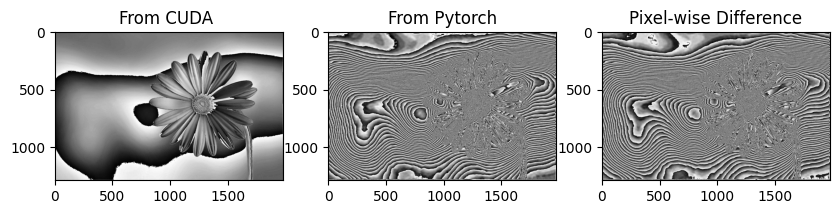

In [68]:

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def show_pixel_difference(image1_path, image2_path):
    # Open images
    image1 = Image.open(image1_path).convert('L')  # Convert to grayscale
    image2 = Image.open(image2_path).convert('L')  # Convert to grayscale

    # Convert images to numpy arrays
    image1_array = np.array(image1)
    image2_array = np.array(image2)
    print(image1_array.shape)
    print(image2_array.shape)

    # Compute pixel-wise absolute difference
    diff_array = np.abs(image1_array - image2_array)

    # print the max difference value
    # print("max difference value:", np.max(diff_array))
    # print("min difference value:", np.min(diff_array))

    # count the number of different pixels
    print("number of different pixels:", np.sum(diff_array>0))
    # % of different pixels
    print("% of different pixels:", np.sum(diff_array>0)/diff_array.size)

    # sum of all the difference values and average difference value
    print("sum of all the difference values:", np.sum(diff_array))
    print("average difference value:", np.sum(diff_array)/(diff_array.size*255))




    # Plot the difference
    plt.figure(figsize=(10, 5))

    # Original images
    plt.subplot(1, 3, 1)
    plt.imshow(image1_array, cmap='gray')
    plt.title('From CUDA ')

    plt.subplot(1, 3, 2)
    plt.imshow(image2_array, cmap='gray')
    plt.title('From Pytorch')

    # Pixel-wise absolute difference
    plt.subplot(1, 3, 3)
    plt.imshow(diff_array, cmap='gray')
    plt.title('Pixel-wise Difference')

    plt.show()

# Example usage:
image1_path = 'out/image_0.jpg'
image2_path = 'out/output_0.png'
show_pixel_difference(image1_path, image2_path)


In [17]:
# !nvcc K1_1_34_2_22.cu -o K1_1_34_2_22.exe
# !nvcc K2_1_34_2_22.cu -o K2_1_34_2_22.exe
!nvcc K3_1_34_2_22.cu -o K3_1_34_2_22.exe
# !nvcc k1c.cu -o k1c.out
# !nvcc k2c.cu -o k2c.out
# !nvcc k3c.cu -o k3c.out

e:\CMP2024\cmp2024\computer engineering 10\parallel computing\labs\lab4\submit\1_34_2_22\stb/stb_image.h(4275): warning #550-D: variable "old_limit" was set but never used
     unsigned int cur, limit, old_limit;
                              ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"

e:\CMP2024\cmp2024\computer engineering 10\parallel computing\labs\lab4\submit\1_34_2_22\stb/stb_image.h(5182): warning #550-D: variable "idata_limit_old" was set but never used
                 stbi__uint32 idata_limit_old = idata_limit;
                              ^

e:\CMP2024\cmp2024\computer engineering 10\parallel computing\labs\lab4\submit\1_34_2_22\stb/stb_image.h(6969): warning #550-D: variable "out_size" was set but never used
        int out_size = 0;
            ^

e:\CMP2024\cmp2024\computer engineering 10\parallel computing\labs\lab4\submit\1_34_2_22\stb/stb_image.h(6970): warning #550-D: variable "delays_size" was set but never used
        int delay

In [8]:
!./K2_1_34_2_22.exe img outk2/7 5 maskA7.txt

'.' is not recognized as an internal or external command,
operable program or batch file.


In [67]:
!./k2.out img out 1 mask25.txt

Reading image...
width = 1980, height = 1289, comp = 3
Size of the vector: 7656660


In [39]:
!./K3_1_34_2_22.exe img outk3/7 5 mask7.txt

Reading image...
width = 1980, height = 1289, comp = 3
Size of the vector: 7656660


In [16]:
!python B_1_34_2_22.py img outk3/python/7 5 mask7.txt

input_images torch.Size([5, 3, 280, 280])
dim of input_images 3
output_images torch.Size([5, 1, 280, 280])
Convolution execution time: 0.005669991175333659 seconds
Convolution execution time: 5.669991175333659 ms


In [22]:
# write a python script to generate a mask
import numpy as np
import os
def generate_mask(mask_size, mask_file):
    mask = np.zeros((mask_size, mask_size))
    mask[mask_size//2, mask_size//2] = 1
    np.savetxt(mask_file, mask, fmt='%d', delimiter=' ', header=str(mask_size), comments='')
    print(f"Mask of size {mask_size} generated and saved to {mask_file}")

mask_size = 25
mask_file = 'mask25.txt'
generate_mask(mask_size, mask_file)



Mask of size 25 generated and saved to mask25.txt
